In [21]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=UserWarning)
warnings.filterwarnings('ignore',category=ImportWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import category_encoders as ce
from scipy.stats import randint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from BorutaShap import BorutaShap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.utils.fixes import loguniform
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import joblib
import operator

## Import data from nfl-data-py
##### https://pypi.org/project/nfl-data-py/

In [2]:
# Import csv file from nfl-data-py
df = pd.read_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/play_predictions/output_files/nfl_post_processing_run_pass_classification_data.csv')

df.shape

(34252, 83)

In [3]:
# Print columns with missing values
print(df.columns[df.isnull().any()].tolist())

[]


In [4]:
# Convert binary columns to integers
binary_columns = df.columns[df.isin([0,1]).all()].tolist()
df[binary_columns] = df[binary_columns].apply(pd.to_numeric, downcast='integer', errors='coerce', axis=1)

df.sample(2).style

,posteam,play_type,surface,drive_start,week,goal_to_go,shotgun,no_huddle,defteam_score,score_differential,no_score_prob,safety_prob,spread_line,div_game,play_sequence_game,run_formation,dtg_99to95,dtg_94to90,dtg_40to31,dtg_30to21,dtg_20to11,dtg_10to06,dtg_05to01,prev1_big_play_pass,prev2_big_play_pass,prev3_big_play_pass,prev1_big_play_run,prev2_big_play_run,prev3_big_play_run,prev1_negative_pass,prev2_negative_pass,prev3_negative_pass,prev1_negative_run,prev2_negative_run,prev3_negative_run,prev1_play_off_penalty,prev1_play_def_penalty,prev2_play_off_penalty,prev2_play_def_penalty,prev3_play_off_penalty,prev3_play_def_penalty,prev1_play_run_outside,prev1_play_run_inside,prev1_play_pass_deep,prev1_play_pass_short,prev2_play_run_outside,prev2_play_run_inside,prev2_play_pass_deep,prev2_play_pass_short,prev3_play_run_outside,prev3_play_run_inside,prev3_play_pass_deep,prev3_play_pass_short,prev1_incomplete_pass,prev2_incomplete_pass,prev3_incomplete_pass,prev3_yards_gained,prev1_wpa,prev2_wpa,prev3_wpa,prev1_shotgun,prev2_shotgun,prev3_shotgun,prev1_qb_hit,prev2_qb_hit,prev3_qb_hit,prev1_no_huddle,prev2_no_huddle,prev3_no_huddle,prev1_first_down_pass,prev2_first_down_pass,prev3_first_down_pass,prev1_first_down_run,prev2_first_down_run,prev3_first_down_run,prev1_effct_play,prev2_effct_play,prev3_effct_play,remaining_yards_per_down,two_min_warning,ep_sec_ratio,run_ratio_off_priors,run_ratio_def_priors
17798,LA,pass,grass,punt,14,0,1,1,3,4,0.105610,0.004140,3.000000,1,101,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.000000,-0.000145,-0.027327,-0.013763,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,8.000000,0,0.001607,0.083333,0.111111
20661,MIA,run,grass,punt,3,0,0,0,25,-8,0.370822,0.001897,4.000000,0,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0.000000,0.001734,-0.002802,0.036108,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1.000000,0,0.006492,0.350000,0.500000


In [5]:
# Target frequency
target_count = df.play_type.value_counts(normalize=True)
target_count

play_type
pass    0.595702
run     0.404298
Name: proportion, dtype: float64

In [6]:
df['play_type'] = np.where(df['play_type'] == 'pass', 1, 0)

## Train test split data
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [7]:
# split data into target and feature datasets
X, y = df.loc[:, df.columns != 'play_type'], df['play_type']

initial_features = X.columns.to_list()

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=67)

print(X_train.shape[1], 'features before feature selection')

82 features before feature selection


## Encode categorical features
##### https://contrib.scikit-learn.org/category_encoders/leaveoneout.html

In [8]:
# Create list of features for each dtype
categorical_feat = list(X_train.select_dtypes(include='object'))

# One hot encoding of categorical features
# encoder = ce.OneHotEncoder(return_df=True, cols=categorical_feat, use_cat_names=True)

# Encoded column represents mean response over all rows for this category, providing one-column representation while avoiding direct response leakage
encoder = ce.LeaveOneOutEncoder(return_df=True, cols=categorical_feat)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

print(X_train.shape[1], 'features after categorical encoding')

82 features after categorical encoding


## BorutaShap Feature selection
##### https://pypi.org/project/BorutaShap/
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [9]:
# Specify feature selection model
feature_model = GradientBoostingClassifier(loss='log_loss',
                                           n_estimators=300,
                                           max_depth=40,
                                           max_features=0.4,
                                           max_leaf_nodes=30,
                                           subsample=0.5,
                                           tol=1e-06,
                                           learning_rate=0.05,
                                           min_samples_split=0.05,
                                           criterion='friedman_mse',
                                           random_state=67,
                                           )

In [10]:
# no model selected default is Random Forest
Feature_Selector = BorutaShap(model=feature_model,
                              importance_measure='shap',
                              classification=True,
                              percentile=100,
                              pvalue=0.05,
                              )

Feature_Selector.fit(X=X_train,
                     y=y_train,
                     n_trials=300,
                     sample=False,
                     train_or_test='test',
                     normalize=True,
                     verbose=True,
                     random_state=67,
                     )

  0%|          | 0/300 [00:00<?, ?it/s]

25 attributes confirmed important: ['dtg_05to01', 'drive_start', 'remaining_yards_per_down', 'prev1_wpa', 'prev1_effct_play', 'defteam_score', 'prev1_big_play_run', 'prev3_shotgun', 'shotgun', 'run_ratio_off_priors', 'play_sequence_game', 'posteam', 'ep_sec_ratio', 'run_ratio_def_priors', 'two_min_warning', 'surface', 'prev1_shotgun', 'week', 'prev2_wpa', 'no_score_prob', 'spread_line', 'safety_prob', 'prev2_shotgun', 'goal_to_go', 'score_differential']
57 attributes confirmed unimportant: ['prev3_play_pass_short', 'prev3_first_down_run', 'dtg_10to06', 'prev1_no_huddle', 'prev2_play_run_outside', 'prev3_play_def_penalty', 'prev3_negative_run', 'dtg_40to31', 'prev2_play_off_penalty', 'prev3_big_play_run', 'prev2_first_down_pass', 'dtg_30to21', 'prev1_play_pass_deep', 'div_game', 'prev2_negative_run', 'prev2_qb_hit', 'prev2_play_pass_short', 'prev3_effct_play', 'prev1_qb_hit', 'prev1_play_pass_short', 'prev2_big_play_run', 'prev1_play_run_inside', 'prev3_negative_pass', 'prev1_play_run_o

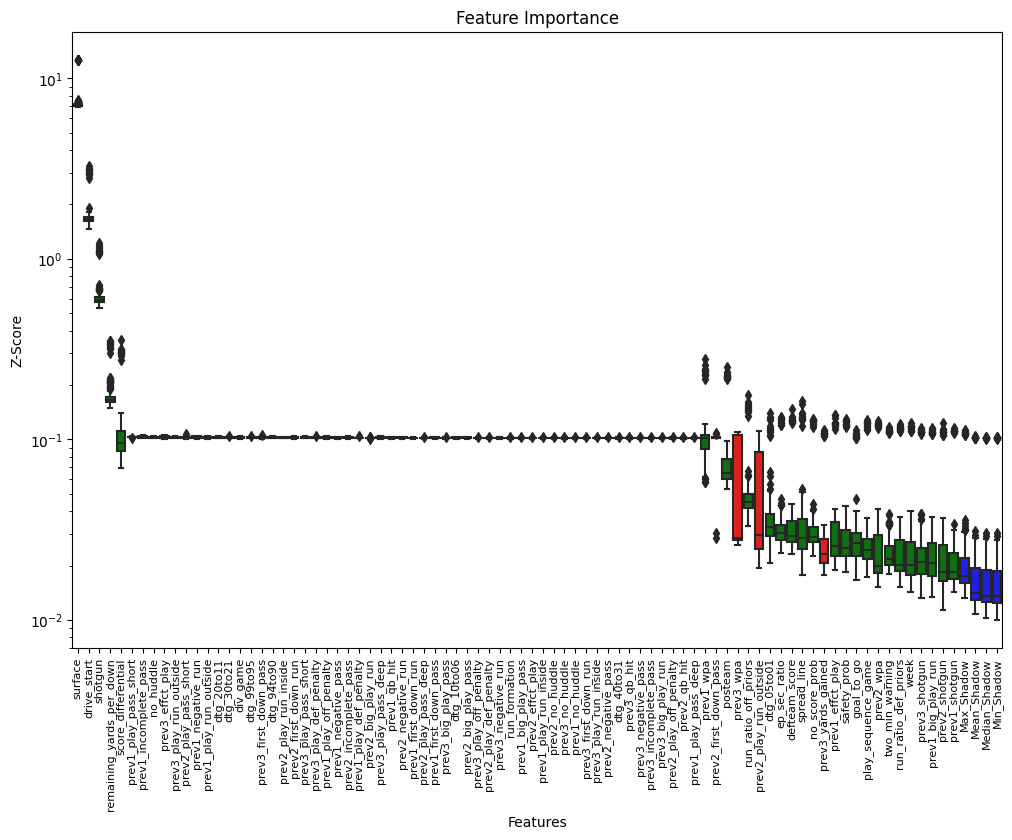

In [11]:
Feature_Selector.plot(which_features='all')

In [12]:
# Drops features that were identified by BorutaShap as not important
features_to_remove = Feature_Selector.features_to_remove

X_train = X_train.drop(columns=features_to_remove)
X_test = X_test.drop(columns=features_to_remove)

# Print the shape of the new datasets
print('Training features:', X_train.shape[1])
print('Testing features:', X_test.shape[1])
print('Remaining features:', X_train.columns.to_list())

Training features: 25
Testing features: 25
Remaining features: ['posteam', 'surface', 'drive_start', 'week', 'goal_to_go', 'shotgun', 'defteam_score', 'score_differential', 'no_score_prob', 'safety_prob', 'spread_line', 'play_sequence_game', 'dtg_05to01', 'prev1_big_play_run', 'prev1_wpa', 'prev2_wpa', 'prev1_shotgun', 'prev2_shotgun', 'prev3_shotgun', 'prev1_effct_play', 'remaining_yards_per_down', 'two_min_warning', 'ep_sec_ratio', 'run_ratio_off_priors', 'run_ratio_def_priors']


## Baseline model
##### https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [13]:
# Create and fit baseline model to compare performance
baseline_model = DummyClassifier(strategy='most_frequent', random_state=67)
baseline_model.fit(X_train, y_train)

# Calculate model accuracy on test data
y_baseline_pred = baseline_model.predict(X_test)
accuracy_score(y_test, y_baseline_pred)
print(f"Baseline test accuracy: {(round(accuracy_score(y_test,y_baseline_pred),3)*100)}%")

Baseline test accuracy: 60.0%


## Model pipeline
##### https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
##### https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
##### https://imbalanced-learn.org/stable/references/over_sampling.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
##### https://xgboost.readthedocs.io/en/stable/parameter.html

In [14]:
# Create feature type lists for column transform stage of the pipeline
ordinal_features = X_train.columns[X_train.isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]).all()].tolist()
categorical_features = list(X_train.select_dtypes(include='object'))
boolean_features = X_train.columns[X_train.isin([0, 1]).all()].tolist()

numeric_features = [x for x in X_train.columns if x not in ordinal_features]
numeric_features = [x for x in numeric_features if x not in categorical_features]
numeric_features = [x for x in numeric_features if x not in boolean_features]

# print('categorical features:', len(categorical_features), ':', categorical_features)
print('ordinal features:', len(ordinal_features), ':', ordinal_features)
print('boolean features:', len(boolean_features), ':', boolean_features)
print('numeric features:', len(numeric_features), ':', numeric_features)

ordinal features: 1 : ['week']
boolean features: 9 : ['goal_to_go', 'shotgun', 'dtg_05to01', 'prev1_big_play_run', 'prev1_shotgun', 'prev2_shotgun', 'prev3_shotgun', 'prev1_effct_play', 'two_min_warning']
numeric features: 15 : ['posteam', 'surface', 'drive_start', 'defteam_score', 'score_differential', 'no_score_prob', 'safety_prob', 'spread_line', 'play_sequence_game', 'prev1_wpa', 'prev2_wpa', 'remaining_yards_per_down', 'ep_sec_ratio', 'run_ratio_off_priors', 'run_ratio_def_priors']


In [15]:
# Outlier removal
def IQR_Outliers(x, features):

    out_index_list = []
        
    for col in features:
        q1 = np.nanpercentile(x[col], 25.)
        q3 = np.nanpercentile(x[col], 75.)
        
        cut_off = (q3 - q1) * 1.5
        upper, lower = q3 + cut_off, q1 - cut_off
                
        outliers_index = x[col][(x[col] < lower) | (x[col] > upper)].index.tolist()
        out_index_list.extend(outliers_index)
        
    # Remove duplicates
    list(set(out_index_list)).sort()

In [16]:
# Specify the transformations per data type
num_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                            ('iqr_outlier', IQR_Outliers(X_train, numeric_features)),
                            ('power_trans', PowerTransformer(method='yeo-johnson', copy=False)),
                            ('std_scaler', StandardScaler()),
                           ])

cat_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('onehot_encoder', OneHotEncoder(sparse=False, handle_unknown='raise')),
                           ])

ord_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('ordinal_encoder', OrdinalEncoder()),
                            ('std_scaler', StandardScaler()),
                           ])
                                
Column_Transform = ColumnTransformer(transformers=[('numeric_transform', num_trans, numeric_features),
                                                  ('categorical_transform', cat_trans, categorical_features),
                                                  ('ordinal_transform', ord_trans, ordinal_features),
                                                  ],
                                    remainder='passthrough',
                                    )

In [33]:
# Specify number of target classes
n_classes = y_train.nunique()

# Specify HalvingRandomSearchCV halving_parameter (aka factor)
halving_parameter = 2.0

# Specify the HalvingRandomSearchCV minimum/maximum resources
max_resource = 2500
resource_divisor = 2.0
min_resource = int(round((max_resource / resource_divisor), 0))

In [40]:
def random_search():
    
    pipeline1 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', RandomForestClassifier()),
    ])
    
    pipeline2 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', ExtraTreesClassifier()),
    ])
    
    pipeline3 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', GradientBoostingClassifier()),
    ])

    # RandomForestClassifier
    parameters1 = {
    'clf__criterion': ['gini','entropy'],
    'clf__max_features': loguniform(0.10, 0.75),
    'clf__max_depth': randint(5, 40),
    'clf__min_samples_split': loguniform(0.10, 0.60),
    'clf__min_samples_leaf': loguniform(0.10, 0.60),
    'clf__min_impurity_decrease': loguniform(1e-09, 1e-03),
    'clf__min_weight_fraction_leaf':  loguniform(0.15, 0.70),
    'clf__ccp_alpha':  loguniform(1e-08, 1e-03),
    'clf__bootstrap': [True, False],
    'clf__oob_score': [False],
    'clf__warm_start': [True, False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }
    
    # ExtraTreesClassifier
    parameters2 = {
    'clf__criterion': ['gini'],
    'clf__max_depth': randint(10, 50),
    'clf__max_features': loguniform(0.20, 0.95),
    'clf__max_leaf_nodes': [None],
    'clf__max_samples': [None], #loguniform(0.35, 0.75),
    'clf__min_samples_split': loguniform(0.10, 0.50),
    'clf__min_samples_leaf': loguniform(0.10, 0.50),
    'clf__min_weight_fraction_leaf': loguniform(0.10, 0.60),
    'clf__min_impurity_decrease': loguniform(1e-09, 1e-03),
    'clf__ccp_alpha': loguniform(1e-08, 1e-02),
    'clf__bootstrap': [True, False],
    'clf__oob_score': [False],
    'clf__warm_start': [True, False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }
            
    # GradientBoostingClassifier
    parameters3 = {
    'clf__loss': ['log_loss'],
    'clf__max_features': loguniform(0.10, 0.50),
    'clf__learning_rate': loguniform(1e-07, 1e-02),
    'clf__ccp_alpha': loguniform(1e-07, 1e-02),
    'clf__max_depth': randint(10, 40),
    'clf__max_leaf_nodes': randint(2, 20),
    'clf__min_samples_split': loguniform(0.25, 0.60),
    'clf__min_impurity_decrease': loguniform(1e-08, 1e-02),
    'clf__min_samples_leaf': loguniform(0.25, 0.50),
    'clf__n_iter_no_change': [150, 200, None],
    'clf__tol': loguniform(1e-08, 1e-04),
    'clf__validation_fraction': loguniform(0.05, 0.15),
    'clf__warm_start': [False],
    'clf__random_state': [67],
    }

    pars = [parameters1, parameters2, parameters3]
    pips = [pipeline1, pipeline2, pipeline3]

    result = []
    
    for i in range(len(pars)):
        
        rs = HalvingRandomSearchCV(pips[i],
                                   pars[i],
                                   factor=halving_parameter,
                                   resource='clf__n_estimators',
                                   n_candidates='exhaust',
                                   min_resources=min_resource,
                                   max_resources=max_resource,
                                   scoring='balanced_accuracy',
                                   aggressive_elimination=False,
                                   return_train_score=True,
                                   refit=True,
                                   cv=10,
                                   n_jobs=6,
                                   verbose=1,
                                   random_state=67,
                                   error_score='raise',
                                  )

        # Fit models on training data
        rs = rs.fit(X_train, y_train)
        
        # Apply models to test data to determine model performance
        y_pred = rs.predict(X_test)
        y_pred_prob = rs.predict_proba(X_test)[:, 1]

        # print("HalvingRandomSearchCV completed subsearch")
        print(" ")
        print(" ")
        
        # storing model results
        result.append({
        'grid': rs,
        'cv results': rs.cv_results_,
        'best train balanced accuracy score': rs.best_score_,
        'best params': rs.best_params_, 
        'best estimator': rs.best_estimator_,
        'feature importance': rs.best_estimator_.named_steps['clf'].feature_importances_,
        'best test balanced accuracy score': balanced_accuracy_score(y_test, y_pred),
        'best test roc auc score': roc_auc_score(y_test, y_pred_prob),
        'test classification report': classification_report(y_test, y_pred, target_names=['pass','run']),
        'cv': rs.cv,
        'model #': i + 1
        })

    # sorting results by best test score
    result = sorted(result, key=operator.itemgetter('best test balanced accuracy score'), reverse=True)
    
    print('Best Models:')
    print(' ')
    for element in result:
        if element['model #']==1:
            print('Random Forest classifier: ')
        elif element['model #']==2:
            print('ExtraTrees classifier: ')
        elif element['model #']==3:
            print('GradientBoosting classifier: ')
        else:
            print('Other: ')  
        print('Parameters:  ' + str(element['best params']))
        print(' ')
        print('Train balanced accuracy score:  ' + str(element['best train balanced accuracy score']))
        print('Test balanced accuracy score:   ' + str(element['best test balanced accuracy score']))
        print('Test roc auc score:   ' + str(element['best test roc auc score']))
        print('-----------------------')

        #ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        #plt.show()
        print(' ')

    # Save best model as pickle file
    joblib.dump(rs.best_params_, r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/play_predictions/output_files/run_pass_classifier_results.pkl', compress=1)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1250
max_resources_: 2500
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 1250
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 1
n_resources: 2500
Fitting 10 folds for each of 1 candidates, totalling 10 fits
 
 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1250
max_resources_: 2500
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 1250
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 1
n_resources: 2500
Fitting 10 folds for each of 1 candidates, totalling 10 fits
 
 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1250
max_resources_: 2500
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 1250
Fitting 10 folds for each of 2 ca

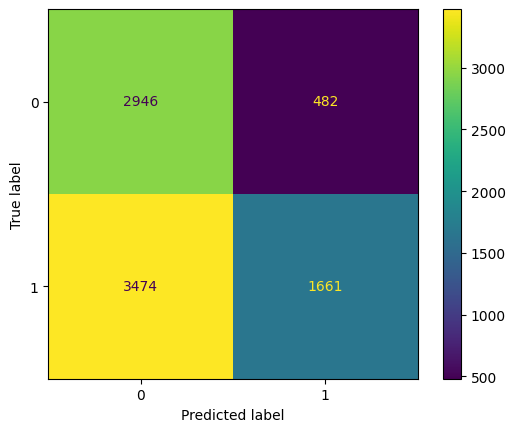

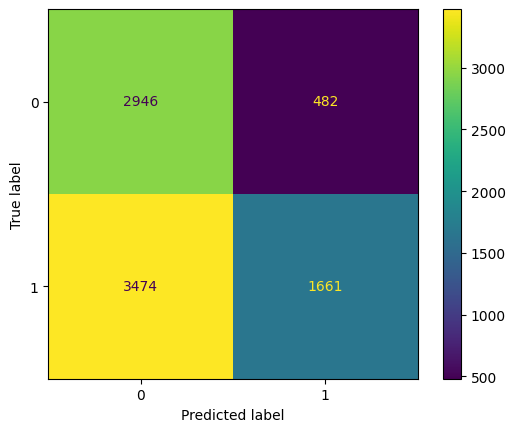

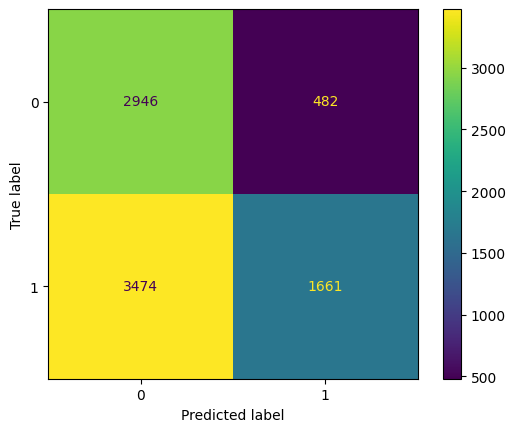

In [41]:
%%capture --no-stdout --no-display
random_search()

In [20]:
# Load best model
best_model = joblib.load(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/play_predictions/output_files/run_pass_classifier_results.pkl')
best_model

{'clf__ccp_alpha': 0.0015254771955752705,
 'clf__learning_rate': 0.03771983912235019,
 'clf__loss': 'log_loss',
 'clf__max_depth': 42,
 'clf__max_features': 0.40793199792771945,
 'clf__max_leaf_nodes': 5,
 'clf__min_impurity_decrease': 1.737767690156847e-07,
 'clf__min_samples_leaf': 0.3654403493888344,
 'clf__min_samples_split': 0.38539690284418326,
 'clf__n_iter_no_change': 150,
 'clf__random_state': 67,
 'clf__tol': 0.00047341797160809016,
 'clf__validation_fraction': 0.12434462317352644,
 'clf__warm_start': False,
 'clf__n_estimators': 1250}